# Process pseudomonas data
This notebook trains a VAE on the PAO1 and PA14 RNA-seq compendia to support the analysis in https://github.com/greenelab/core-accessory-interactome

1. Selects template experiment from the compendium
2. Normalizes the gene expression data from the RNA-seq Pseudomonas compendium
3. Train VAE on the normalized data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [GEOD-33245](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-33245/?s_sortby=col_8&s_sortorder=ascending), as the template experiment, which contains multiple different comparisons including WT vs *crc* mutants, WT vs *cbr* mutants in different conditions.

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_pa14_rnaseq.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# Column header containing sample ids
metadata_colname = params["metadata_colname"]

# Template experiment ID
project_id = params["project_id"]

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params["shared_genes_filename"]

# Output files of pseudomonas template experiment data
raw_template_filename = params["raw_template_filename"]
processed_template_filename = params["processed_template_filename"]

# Output files of pseudomonas compendium data
# raw_compendium_filename = params['raw_compendium_filename']
processed_compendium_filename = params["processed_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params["scaler_filename"]

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", f"{project_id}_process_samples.tsv"
)

### Normalize compendium
The compendium is MR normalized, but here we will 0-1 normalize it

In [4]:
process.normalize_compendium(
    processed_compendium_filename,
    normalized_compendium_filename,
    scaler_filename,
)
"""process.process_raw_compendium_pseudomonas(
    raw_compendium_filename,
    processed_compendium_filename,
    normalized_compendium_filename,
    scaler_filename,
)"""

input: dataset contains 576 samples and 5891 genes


'process.process_raw_compendium_pseudomonas(\n    raw_compendium_filename,\n    processed_compendium_filename,\n    normalized_compendium_filename,\n    scaler_filename,\n)'

In [5]:
test = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)

In [6]:
test.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,0.149,0.015,0.004,0.071,0.084,0.007,0.032,0.017,0.062,0.017,...,0.073,0.295,0.135,0.033,0.0,0.008,0.201,0.160,0.074,0.054
ERX1477380,0.134,0.026,0.005,0.089,0.129,0.009,0.030,0.029,0.105,0.029,...,0.082,0.240,0.092,0.021,0.0,0.003,0.095,0.225,0.030,0.087
ERX1477381,0.115,0.047,0.027,0.108,0.176,0.012,0.035,0.038,0.109,0.015,...,0.141,0.235,0.095,0.018,0.0,0.002,0.087,0.245,0.023,0.031
ERX2174773,0.024,0.034,0.014,0.002,0.026,0.003,0.008,0.003,0.153,0.041,...,0.219,0.077,0.141,0.068,0.0,0.030,0.056,0.344,0.032,0.043
ERX2174774,0.031,0.025,0.014,0.001,0.021,0.003,0.004,0.005,0.161,0.025,...,0.230,0.056,0.126,0.067,0.0,0.034,0.059,0.456,0.030,0.049


## Get raw pseudomonas template experiment

In [7]:
# The function to pull out the template experiment from the compendium in this environment's version of ponyo
# doesn't allow us to pass in a metadata file and instead assumes a fixed set of metadata files.
# To manually work around this, we will locally define the functions here
def get_sample_ids_tmp(
    metadata_filename, delimiter, experiment_colname, experiment_id, sample_id_colname
):
    """
    Returns sample ids (found in gene expression df) associated with
    a given list of experiment ids (found in the metadata)

    Arguments
    ----------
    metadata_filename: str
        Metadata file path. An example metadata file can be found
        here: https://github.com/greenelab/ponyo/blob/master/human_tests/data/metadata/recount2_metadata.tsv

    delimiter: str
        Delimiter for metadata file

    experiment_colname: str
        Column header that contains the experiment ids

    experiment_id: str
        Experiment id selected to retrieve sample ids for

    sample_id_colname: str
        Column header that contains sample id that maps expression data
        and metadata

    """

    # Read in metadata
    metadata = pd.read_csv(metadata_filename, header=0, sep=delimiter, index_col=None)

    # Set index column to experiment id column
    metadata.set_index(experiment_colname, inplace=True)

    # Select samples associated with experiment id
    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[sample_id_colname])

    return sample_ids


def process_raw_template_pseudomonas_tmp(
    processed_compendium_filename,
    project_id,
    metadata_filename,
    metadata_delimiter,
    experiment_colname,
    metadata_colname,
    raw_template_filename,
):
    """
    Create processed pseudomonas template data file based on
    processed compendium file (`compendium_filename`),
    drop sample rows if needed, and save updated
    template data on disk.
    """

    # Get sample ids associated with selected project id
    sample_ids = get_sample_ids_tmp(
        metadata_filename,
        metadata_delimiter,
        experiment_colname,
        project_id,
        metadata_colname,
    )

    # Get samples from experiment id
    processed_compendium = pd.read_csv(
        processed_compendium_filename, header=0, index_col=0, sep="\t"
    )
    template_data = processed_compendium.loc[sample_ids]

    template_data.to_csv(raw_template_filename, sep="\t")

In [8]:
metadata_filename = "data/metadata/SraRunTable.csv"

process_raw_template_pseudomonas_tmp(
    processed_compendium_filename,
    project_id,
    metadata_filename,
    ",",
    "SRA_study",
    metadata_colname,
    raw_template_filename,
)

In [9]:
test2 = pd.read_csv(raw_template_filename, sep="\t", index_col=0, header=0)

In [10]:
test2.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
SRX1740204,179.103190,76.046134,33.867541,1142.769777,356.544170,104.303714,31.166448,85.188292,75.838358,5.402184,...,48.619660,19.738751,261.382614,275.719181,0.623329,56.515160,135.054610,156.871124,63.164002,261.382614
SRX1740205,160.820796,65.859945,31.972706,1395.886215,435.939228,115.829263,37.333399,101.470264,58.201812,4.786333,...,45.757345,25.654746,389.798976,251.952580,0.957267,116.212170,125.593383,164.075502,58.776172,296.561205
SRX1740206,156.853998,69.081551,34.540776,695.749907,207.394180,56.820323,20.634749,52.334508,55.325052,4.037234,...,38.877063,23.326238,253.897129,341.220995,1.644799,126.350456,133.826814,136.368776,56.521269,306.829746
SRX1740207,230.669314,54.576966,20.524671,474.399781,174.692938,39.183463,15.393503,47.346684,74.635167,5.364403,...,20.058201,24.722899,173.060294,483.029473,0.466470,113.352160,197.083488,102.156885,72.069583,390.901688
SRX1740208,199.661033,64.058640,32.725610,562.776041,169.372437,59.010541,19.147963,52.743935,86.165834,8.529547,...,27.677510,21.584977,165.890989,368.337180,1.218507,95.043526,143.435650,125.506194,71.717825,330.911616


In [11]:
test2.shape

(6, 5891)

**Note:**
* We are training our VAE model using ALL the data in the compendium.
* The template experiment is using a subset of the samples in the real experiment and using those in the DE analysis in order to ensure the comparison of samples with consistent backgrounds (i.e. some experiments have samples with 3 different biological conditions and for now our statistical test is doing a binary comparison).
* Simulated experiments are generated by shifting the template experiment (using ALL samples in the real experiment) in the latent space. Then dropping the samples to match the template experiment and perform DE analysis.


So there is an inconsistency in the samples used to learn a low-dimensional representation and those used to calculate DE statistics. This inconsistency should not not change the simulated experiments since all samples in the template experiment are moved the same amount in the latent space. The only way for this inconsistency to effect the simulated experiments is if the low dimensional space is significantly different including all the experiment samples vs only including a subset. However, we believe that such few samples will likely not effect the space. Furthermore, the dataset used to train the VAE should be a general representation of gene expression patterns and shouldn't have to be include the template experiment.

### Train VAE

In [12]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 576 samples and 5891 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 432 samples, validate on 144 samples
Epoch 1/120
432/432 [==============================] - 31s 71ms/step - loss: 2285.7304 - val_loss: 2066.2920
Epoch 2/120
432/432 [==============================] - 30s 71ms/step - loss: 2024.0859 - val_loss: 2042.5120
Epoch 3/120
432/432 [==============================] - 33s 76ms/step - loss: 2006.1307 - val_loss: 2010.2319
Epoch 4/120
432/432 [==============================] - 30s 71ms/step - loss: 1989.1777 - val_loss: 1980.5012
Epoch 5/120
432/432 [==============================] - 31s 72ms/step - loss: 1979.8081 - val_loss: 1953.4778
Epoch 6/120
432/432 [==============================] - 30s 69ms/step - loss: 1977.1945 - val_loss: 1955.3486
Epoch 7/120
432/432 [==============================] - 30s 70ms/step - loss: 1969.9221 - val_loss: 1953.2205
Epoch 8/120
432/432 [==============================] - 30s 69ms/step - loss: 1968.7558 - val_loss: 1942.5529
Epoch 9/120
432/432 [==============================] - 30s 70ms/step - loss: 1966

Epoch 73/120
432/432 [==============================] - 31s 71ms/step - loss: 1804.6576 - val_loss: 1825.8965
Epoch 74/120
432/432 [==============================] - 31s 71ms/step - loss: 1806.2761 - val_loss: 1823.9533
Epoch 75/120
432/432 [==============================] - 31s 72ms/step - loss: 1802.5206 - val_loss: 1826.5235
Epoch 76/120
432/432 [==============================] - 31s 71ms/step - loss: 1804.7679 - val_loss: 1831.8176
Epoch 77/120
432/432 [==============================] - 31s 71ms/step - loss: 1806.0745 - val_loss: 1821.6941
Epoch 78/120
432/432 [==============================] - 31s 71ms/step - loss: 1798.9530 - val_loss: 1826.5364
Epoch 79/120
432/432 [==============================] - 31s 71ms/step - loss: 1806.4466 - val_loss: 1823.8791
Epoch 80/120
432/432 [==============================] - 31s 71ms/step - loss: 1803.5540 - val_loss: 1825.0557
Epoch 81/120
432/432 [==============================] - 32s 74ms/step - loss: 1797.3092 - val_loss: 1822.6113
Epoch 82/1

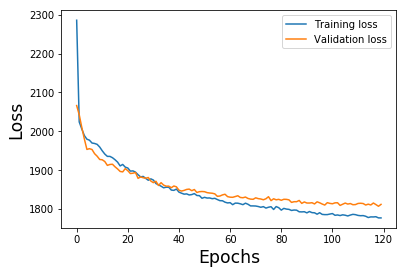

In [13]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)